In [6130]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [6131]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

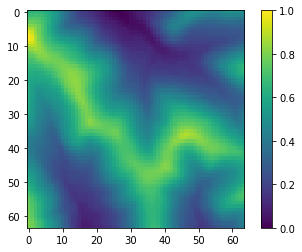

In [6132]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[6498].view(64, 64))
plt.colorbar(p)
plt.show()

In [6133]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7930]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = F.leaky_relu(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [7939]:
vae = VAE().cuda()

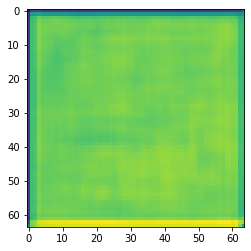

In [7940]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [7941]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    i = 0
    for data in dataloader:
        i += 1
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss, MSE, KLD = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item() / batch_size, MSE.item() / batch_size, KLD.item() / batch_size)
            print(msg)

epoch[1/100], loss=230.318, MSE=223.613, KLD=6.705
epoch[1/100], loss=91.827, MSE=84.928, KLD=6.899
epoch[1/100], loss=73.932, MSE=65.804, KLD=8.129
epoch[1/100], loss=64.988, MSE=56.768, KLD=8.220
epoch[1/100], loss=58.334, MSE=50.623, KLD=7.711
epoch[2/100], loss=50.708, MSE=43.003, KLD=7.704
epoch[2/100], loss=47.972, MSE=40.178, KLD=7.794
epoch[2/100], loss=47.443, MSE=39.538, KLD=7.905
epoch[2/100], loss=46.412, MSE=38.437, KLD=7.975
epoch[2/100], loss=42.564, MSE=35.212, KLD=7.352
epoch[3/100], loss=41.915, MSE=34.784, KLD=7.131
epoch[3/100], loss=42.891, MSE=35.540, KLD=7.352
epoch[3/100], loss=39.954, MSE=32.779, KLD=7.175
epoch[3/100], loss=41.089, MSE=33.333, KLD=7.756
epoch[3/100], loss=38.293, MSE=31.055, KLD=7.238
epoch[4/100], loss=39.504, MSE=31.889, KLD=7.615
epoch[4/100], loss=35.559, MSE=28.154, KLD=7.405
epoch[4/100], loss=33.209, MSE=26.122, KLD=7.087
epoch[4/100], loss=34.597, MSE=27.360, KLD=7.237
epoch[4/100], loss=32.462, MSE=25.369, KLD=7.093
epoch[5/100], loss

epoch[34/100], loss=17.551, MSE=10.963, KLD=6.588
epoch[34/100], loss=18.021, MSE=11.344, KLD=6.677
epoch[34/100], loss=20.185, MSE=13.340, KLD=6.845
epoch[34/100], loss=17.682, MSE=11.151, KLD=6.531
epoch[34/100], loss=18.322, MSE=11.710, KLD=6.612
epoch[35/100], loss=19.556, MSE=12.942, KLD=6.615
epoch[35/100], loss=17.350, MSE=10.747, KLD=6.603
epoch[35/100], loss=18.667, MSE=11.946, KLD=6.721
epoch[35/100], loss=17.026, MSE=10.602, KLD=6.425
epoch[35/100], loss=18.290, MSE=11.731, KLD=6.559
epoch[36/100], loss=19.509, MSE=12.547, KLD=6.962
epoch[36/100], loss=16.879, MSE=10.519, KLD=6.360
epoch[36/100], loss=19.617, MSE=12.795, KLD=6.822
epoch[36/100], loss=16.969, MSE=10.387, KLD=6.582
epoch[36/100], loss=16.929, MSE=10.228, KLD=6.701
epoch[37/100], loss=18.669, MSE=11.906, KLD=6.763
epoch[37/100], loss=16.683, MSE=10.133, KLD=6.550
epoch[37/100], loss=17.708, MSE=11.152, KLD=6.555
epoch[37/100], loss=18.374, MSE=11.772, KLD=6.603
epoch[37/100], loss=17.378, MSE=10.757, KLD=6.621


epoch[67/100], loss=16.502, MSE=9.730, KLD=6.772
epoch[67/100], loss=16.262, MSE=9.475, KLD=6.788
epoch[67/100], loss=16.618, MSE=10.019, KLD=6.599
epoch[67/100], loss=16.590, MSE=9.865, KLD=6.725
epoch[67/100], loss=16.904, MSE=10.205, KLD=6.700
epoch[68/100], loss=17.337, MSE=10.952, KLD=6.385
epoch[68/100], loss=16.764, MSE=10.092, KLD=6.672
epoch[68/100], loss=17.134, MSE=10.222, KLD=6.912
epoch[68/100], loss=17.858, MSE=11.037, KLD=6.821
epoch[68/100], loss=16.036, MSE=9.417, KLD=6.619
epoch[69/100], loss=17.647, MSE=10.655, KLD=6.992
epoch[69/100], loss=17.640, MSE=10.643, KLD=6.997
epoch[69/100], loss=16.599, MSE=10.028, KLD=6.571
epoch[69/100], loss=16.198, MSE=9.677, KLD=6.521
epoch[69/100], loss=17.139, MSE=10.220, KLD=6.918
epoch[70/100], loss=15.713, MSE=8.955, KLD=6.758
epoch[70/100], loss=17.030, MSE=10.337, KLD=6.693
epoch[70/100], loss=16.496, MSE=9.850, KLD=6.646
epoch[70/100], loss=17.118, MSE=10.534, KLD=6.583
epoch[70/100], loss=16.531, MSE=9.852, KLD=6.679
epoch[71

epoch[100/100], loss=15.816, MSE=9.331, KLD=6.485
epoch[100/100], loss=16.137, MSE=9.282, KLD=6.855
epoch[100/100], loss=16.585, MSE=9.717, KLD=6.868
epoch[100/100], loss=15.668, MSE=8.856, KLD=6.811


In [7942]:
torch.cuda.empty_cache()

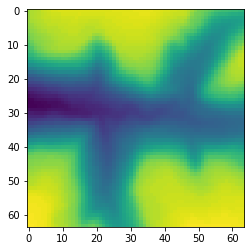

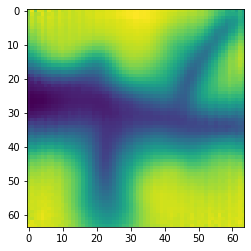

In [7943]:
x = dataset[5948].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [7992]:
#torch.save(vae.state_dict(), './vae_save')

In [7295]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

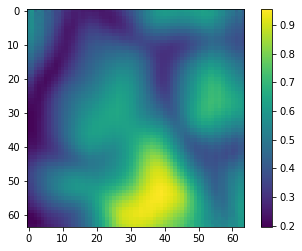

In [7991]:
# Generator
code = torch.FloatTensor(1, 64).normal_()

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()